#### Experiment: 

Compare bayeasian optimization experiments with random hyperparameter search

#### Motivation.

Evaluate bayeasian optimization as a hyperparameter search tool

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *
import re

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [5]:
exps = ['sigopt_test1', 'sigopt_test2', 'sigopt_test3']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [6]:
test_string = '0_learning_'
re.match('^\d+', test_string)[0]

'0'

In [7]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,momentum,name,network,num_classes,on_perc,params_space,performance_metric,stats_mean,stats_std,weight_decay
0,"1_batch_size_test=1024,batch_size_train=256,ch...",0.66006,12,0.49026,0,0.65501,0.65844,0.5520,17,0.4040,...,0.657374,sigopt_test1,resnet18,10,0.252978,"{'bounds': {'max': 0.2, 'min': 0.0001}, 'name'...",val_acc,0.473367,0.2009,0.033410
1,"2_batch_size_test=1024,batch_size_train=256,ch...",0.54744,8,0.39516,0,0.53899,0.53872,0.4595,9,0.1874,...,0.548898,sigopt_test1,resnet18,10,0.958674,"{'bounds': {'max': 0.2, 'min': 0.0001}, 'name'...",val_acc,0.473367,0.2009,0.045435
2,"3_batch_size_test=1024,batch_size_train=256,ch...",0.32850,1,0.29214,16,0.31230,0.30276,0.3089,7,0.1165,...,0.106052,sigopt_test1,resnet18,10,0.869434,"{'bounds': {'max': 0.2, 'min': 0.0001}, 'name'...",val_acc,0.473367,0.2009,0.093472
3,"4_batch_size_test=1024,batch_size_train=256,ch...",0.50326,1,0.44154,19,0.47013,0.44154,0.4273,2,0.1826,...,0.810624,sigopt_test1,resnet18,10,0.106663,"{'bounds': {'max': 0.2, 'min': 0.0001}, 'name'...",val_acc,0.473367,0.2009,0.080203
4,"5_batch_size_test=1024,batch_size_train=256,ch...",0.52088,6,0.38364,0,0.51390,0.51248,0.3881,1,0.2451,...,0.186532,sigopt_test1,resnet18,10,0.646579,"{'bounds': {'max': 0.2, 'min': 0.0001}, 'name'...",val_acc,0.473367,0.2009,0.056150


In [8]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'checkpoint_dir', 'data_dir',
       'dataset_name', 'device', 'experiment_type', 'input_size',
       'learning_rate', 'local_dir', 'model', 'momentum', 'name', 'network',
       'num_classes', 'on_perc', 'params_space', 'performance_metric',
       'stats_mean', 'stats_std', 'weight_decay'],
      dtype='object')

In [9]:
df['experiment_file_name'].unique()

array(['/Users/lsouza/nta/results/sigopt_test1/experiment_state-2020-03-20_02-59-23.json',
       '/Users/lsouza/nta/results/sigopt_test2/experiment_state-2020-03-20_18-07-05.json',
       '/Users/lsouza/nta/results/sigopt_test3/experiment_state-2020-03-25_01-36-27.json'],
      dtype=object)

In [10]:
def fix_name(s):
    if s == '/Users/lsouza/nta/results/sigopt_test1/experiment_state-2020-03-20_02-59-23.json':
        return 'SigOpt-A'
    elif s == '/Users/lsouza/nta/results/sigopt_test2/experiment_state-2020-03-20_18-07-05.json':
        return "SigOpt-B"
    elif s == '/Users/lsouza/nta/results/sigopt_test3/experiment_state-2020-03-25_01-36-27.json':
        return 'Random Search'

df['experiment_file_name'] = df['experiment_file_name'].apply(fix_name)

In [11]:
df['experiment_file_name'].unique()

array(['SigOpt-A', 'SigOpt-B', 'Random Search'], dtype=object)

In [12]:
def get_index(s):
    return int(re.match('^\d+', s)[0])

df['index_pos'] = df['Experiment Name'].apply(get_index)

In [13]:
df['density'] = df['on_perc']

In [14]:
df.iloc[17]

Experiment Name         18_batch_size_test=1024,batch_size_train=256,c...
train_acc_max                                                      0.5637
train_acc_max_epoch                                                    19
train_acc_min                                                     0.13784
train_acc_min_epoch                                                     0
train_acc_median                                                  0.47292
train_acc_last                                                     0.5637
val_acc_max                                                         0.476
val_acc_max_epoch                                                      19
val_acc_min                                                        0.1944
val_acc_min_epoch                                                       0
val_acc_median                                                    0.42475
val_acc_last                                                        0.476
val_acc_all             0     0.1944
1

In [15]:
df.groupby('experiment_file_name')['model'].count()

experiment_file_name
Random Search    300
SigOpt-A         300
SigOpt-B         300
Name: model, dtype: int64

 ## Analysis

In [16]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


In [17]:
agg(['experiment_file_name'])

val_acc_max_epoch val_acc_max                      model
                            round_mean         min    max   mean    std count
experiment_file_name                                                         
Random Search                       10       0.100  0.733  0.483  0.156   300
SigOpt-A                            15       0.168  0.766  0.682  0.097   300
SigOpt-B                            16       0.212  0.762  0.704  0.068   300

In [25]:
def plot_acc_over_time(plot_title):
    plt.figure(figsize=(12,6))
    df_plot = df[df['experiment_file_name'] == plot_title]
    sns.lineplot(df_plot['index_pos'], y=df_plot['val_acc_last'])
    plt.xticks(np.arange(0,300,30))
    plt.ylim(0,0.80)
    plt.title(plot_title)

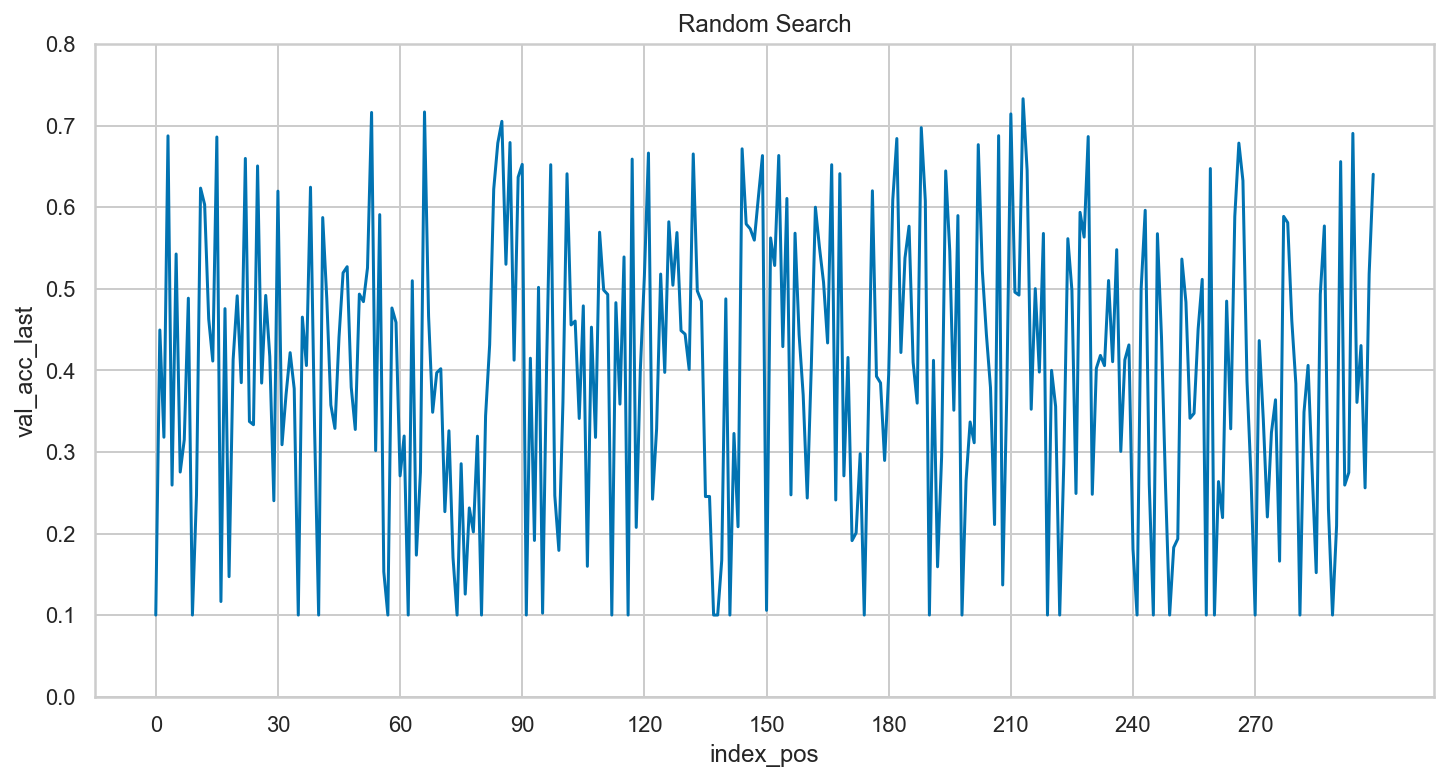

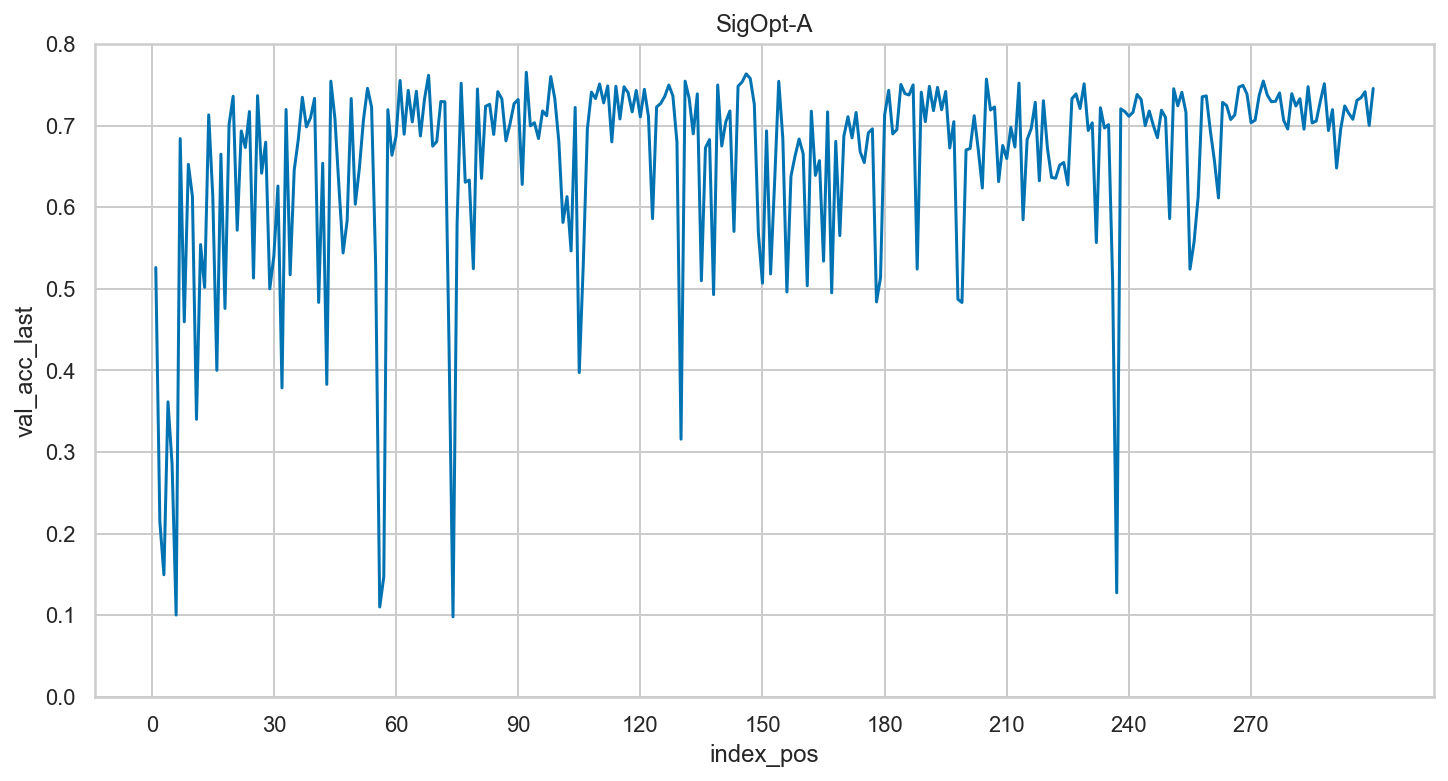

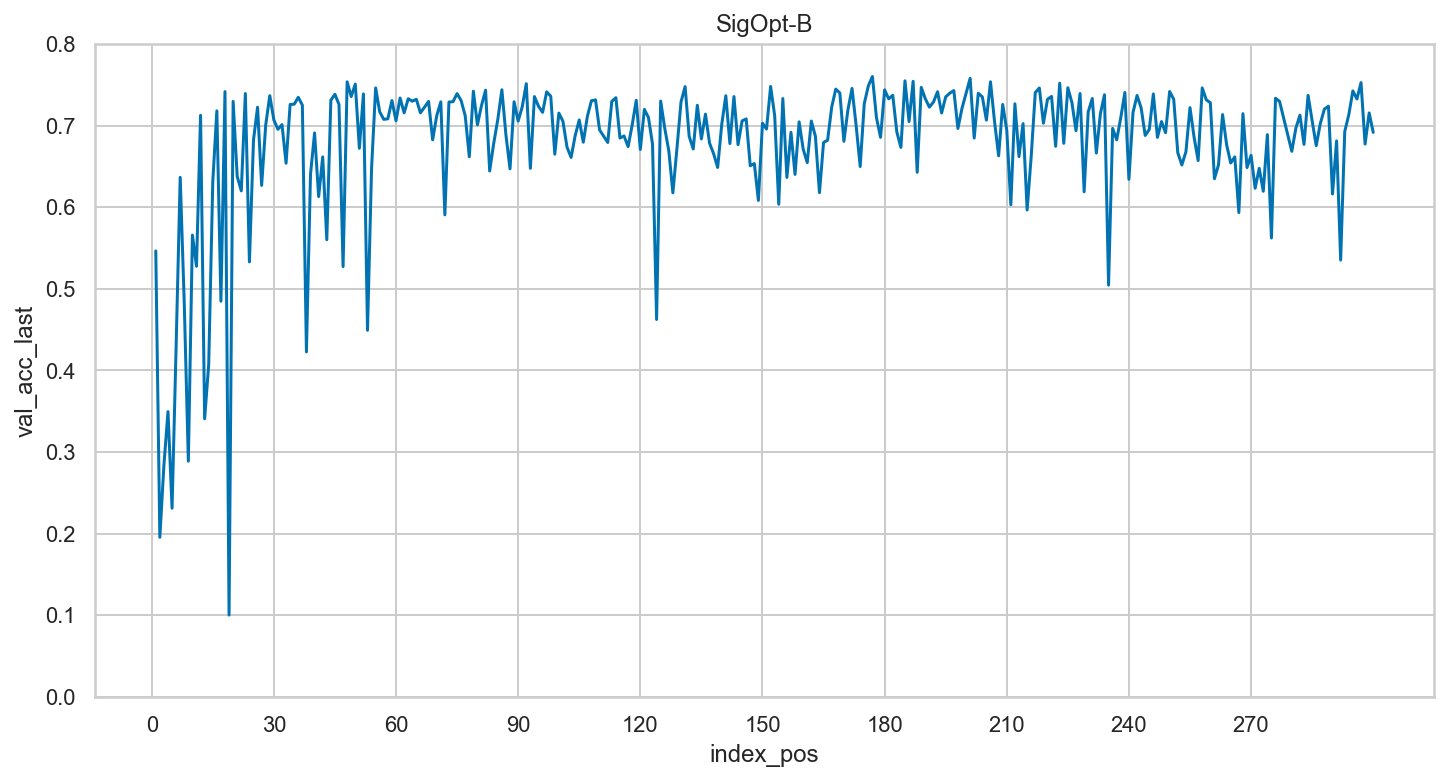

In [26]:
# how to plot?
plot_acc_over_time('Random Search')
plot_acc_over_time('SigOpt-A')
plot_acc_over_time('SigOpt-B')

In [30]:
def accumulate(series):
    series = list(series)
    cum_series = [series[0]]
    for i in range(1, len(series)):
        cum_series.append(max(cum_series[i-1], series[i]))
    return cum_series   

def plot_best_acc_over_time(plot_title):
    plt.figure(figsize=(12,6))
    df_plot = df[df['experiment_file_name'] == plot_title].sort_values('index_pos')
    df_plot['cum_acc'] = accumulate(df_plot['val_acc_last'])
    sns.lineplot(df_plot['index_pos'], y=df_plot['cum_acc'])
    plt.xticks(np.arange(0,301,30))
    plt.ylim(0,0.80)
    plt.title(plot_title)

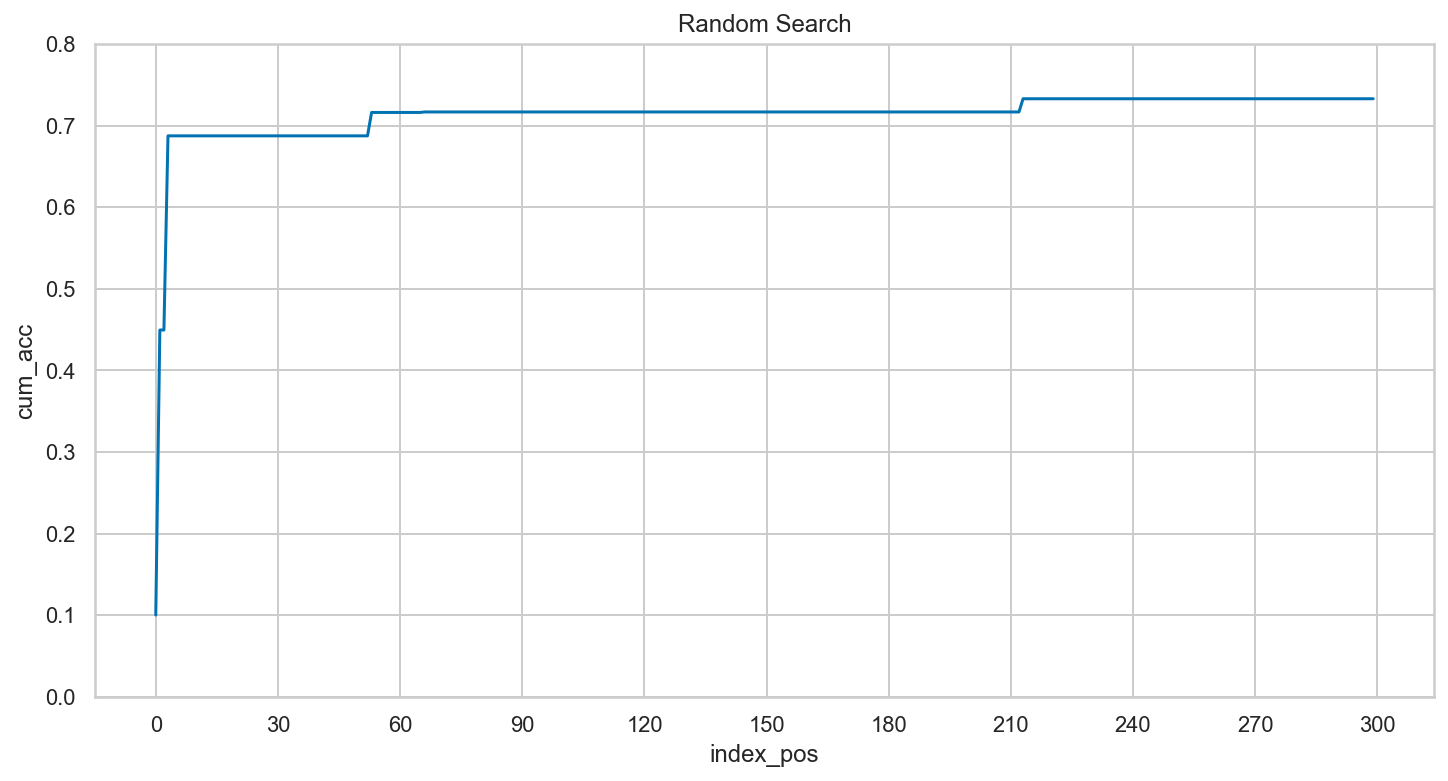

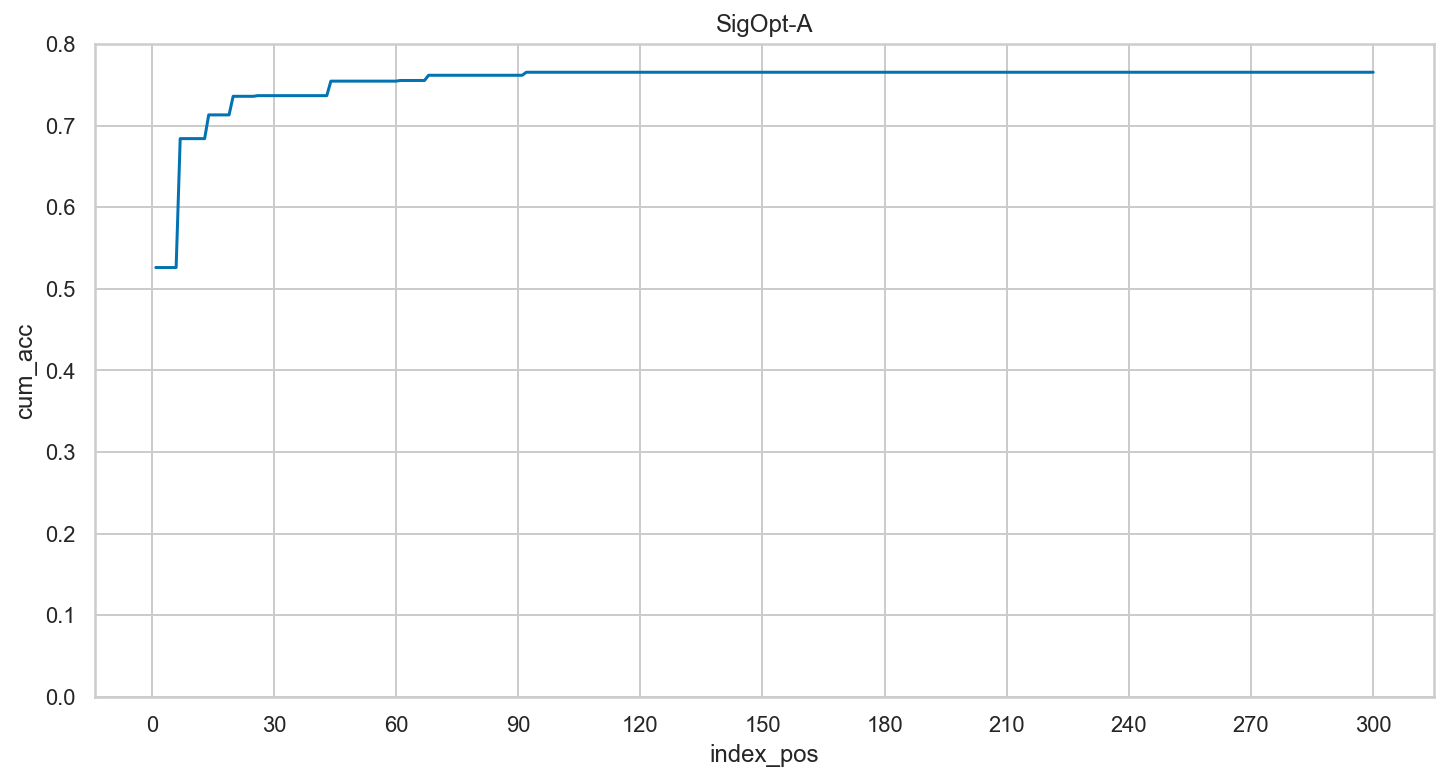

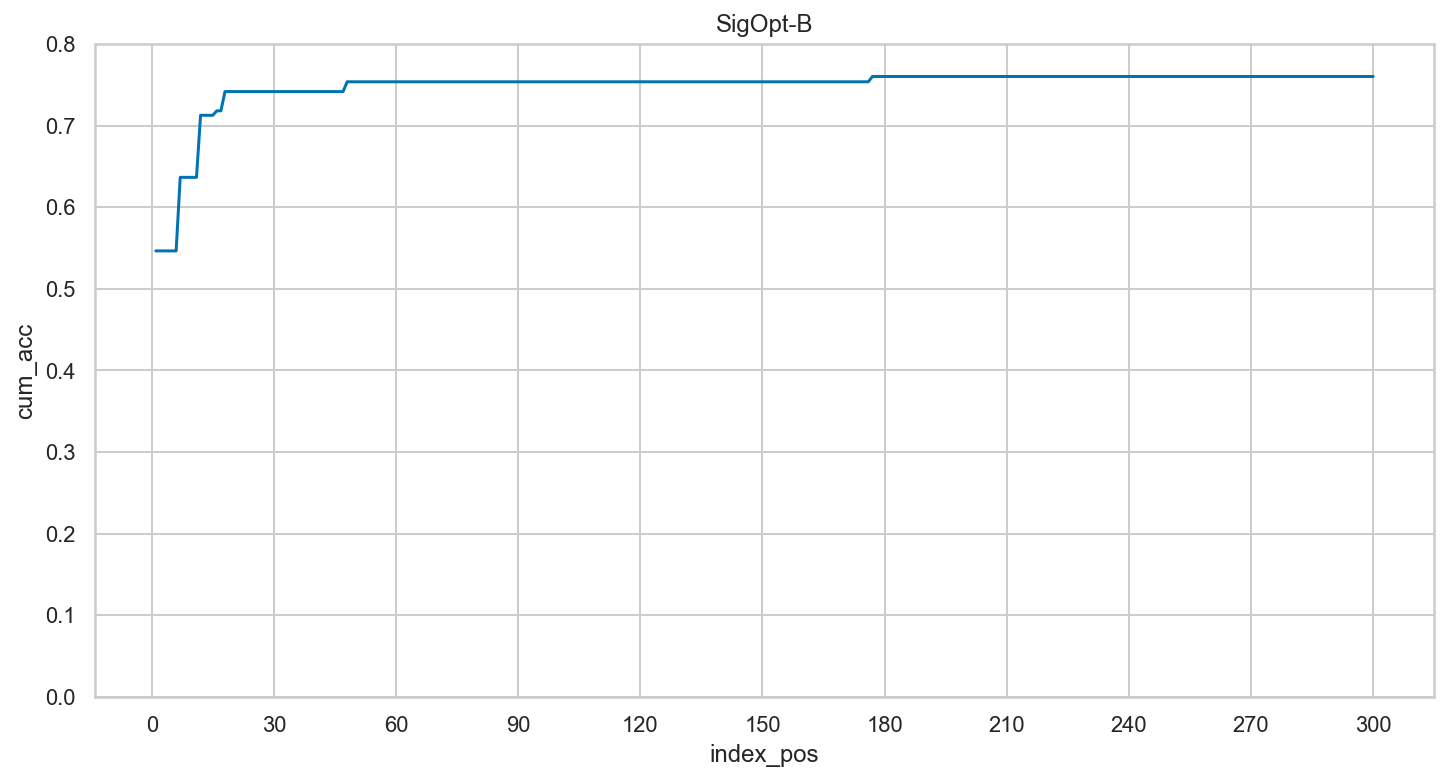

In [32]:
plot_best_acc_over_time('Random Search')
plot_best_acc_over_time('SigOpt-A')
plot_best_acc_over_time('SigOpt-B')

In [37]:
# list top 5 values of each
# show best values
def show_best(experiment):
    df_exp = df[df['experiment_file_name'] == experiment].sort_values('val_acc_last', ascending=False)[:5]
    return df_exp[['index_pos', 'learning_rate', 'density', 'momentum', 'weight_decay', 'val_acc_last']]

In [38]:
show_best('Random Search')

,index_pos,learning_rate,density,momentum,weight_decay,val_acc_last
813,213,0.058898,0.878634,0.574113,0.002438,0.7332
666,66,0.083424,0.770878,0.898470,0.001958,0.7170
653,53,0.008048,0.239059,0.726629,0.027634,0.7164
810,210,0.164996,0.398287,0.549241,0.000841,0.7146
685,85,0.011424,0.580148,0.635030,0.010512,0.7055


In [39]:
show_best('SigOpt-A')

,index_pos,learning_rate,density,momentum,weight_decay,val_acc_last
91,92,0.061866,0.622799,0.844554,0.00001,0.7657
145,146,0.081277,0.408934,0.776824,0.00001,0.7637
67,68,0.057478,0.712429,0.835691,0.00001,0.7620
97,98,0.043534,1.000000,0.842895,0.00001,0.7604
146,147,0.037768,1.000000,0.752623,0.00001,0.7581


In [40]:
show_best('SigOpt-B')

,index_pos,learning_rate,density,momentum,weight_decay,val_acc_last
476,177,0.054299,0.752732,0.587002,0.0,0.7605
500,201,0.154476,0.572523,0.603093,0.0,0.7582
484,185,0.105273,0.725239,0.107731,0.0,0.7552
486,187,0.121463,0.742044,0.079312,0.0,0.7546
505,206,0.148342,0.341144,0.446384,0.0,0.7540
